# Comparing constraints from different surveys

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Define utility functions for plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm
def plot_contours(fisher, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])

    # Argument validation
    assert fisher.shape[0] == fisher.shape[1], "Fisher matrix must be square"
    assert len(pos) == fisher.shape[0], "Position vector dimension must match Fisher matrix"
    assert len(inds) == 2, "Indices must specify a 2D slice of the Fisher matrix"

    cov = inv(fisher)
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellips = []
    for nstd in nstds:
       ellip = Ellipse(xy=pos[inds], width=2.0 * nstd * np.sqrt(vals[0]),
                     height=2.0 * nstd * np.sqrt(vals[1]), angle=theta, **kwargs)
       ellips.append(ellip)
    '''ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstd1 * np.sqrt(vals[0]),
                     height=2.0 * nstd1 * np.sqrt(vals[1]), angle=theta, **kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstd2 * np.sqrt(vals[0]),
                     height=2.0 * nstd2 * np.sqrt(vals[1]), angle=theta, **kwargs)'''

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(fisher, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  mat = fisher
  cov = inv(mat)
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))

def shade_Gaussian(fisher, pos, ind, nstds=[1,2], ax=None, alphas = [.1,.2], **kwargs):
    mu = pos[ind]
    mat = fisher
    cov = inv(mat)
    sigma = np.sqrt(cov[ind,ind])

    if ax is None:
        ax = plt.gca()

    color = 'C0'
    if 'color' in kwargs.keys():
        color = kwargs['color']
    
    num = 100
    if 'num' in kwargs.keys():
        num = kwargs['num']
    
    curve = lambda x: np.exp(-.5*((x-mu)/sigma)**2)

    nstds = np.flip(np.sort(nstds))
    for i in range(len(nstds)):
        X = np.linspace(mu-nstds[i]*sigma, mu+nstds[i]*sigma, num=int(num*nstds[i]/nstds[0]), endpoint=True)
        ax.fill_between(X, curve(X), color=color, alpha=alphas[i])

In [3]:
from numpy import loadtxt
def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

## Baseline parameter set - \{$\Omega_m, \Omega_b, h, n_s, S_8, \gamma$\}

In [4]:
cosmo_param_nr = 6

#Get matrices
fid_vals, fisher_DESY3_baseline = loadFisher(fname='Results/Baseline-S8/Baseline-S8-DESY3-3x2.csv')
fid_vals, fisher_Euclid_baseline = loadFisher(fname='Results/Baseline-S8/Baseline-S8-Euclid-3x2.csv')

#Marginalize over nuisance parameters
fisher_DESY3_baseline = np.linalg.inv(np.linalg.inv(fisher_DESY3_baseline)[:cosmo_param_nr, :cosmo_param_nr])
fisher_Euclid_baseline = np.linalg.inv(np.linalg.inv(fisher_Euclid_baseline)[:cosmo_param_nr, :cosmo_param_nr])

fid_vals = fid_vals[:cosmo_param_nr]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 0.98, '3x2pt Baseline Parameter Constraints')

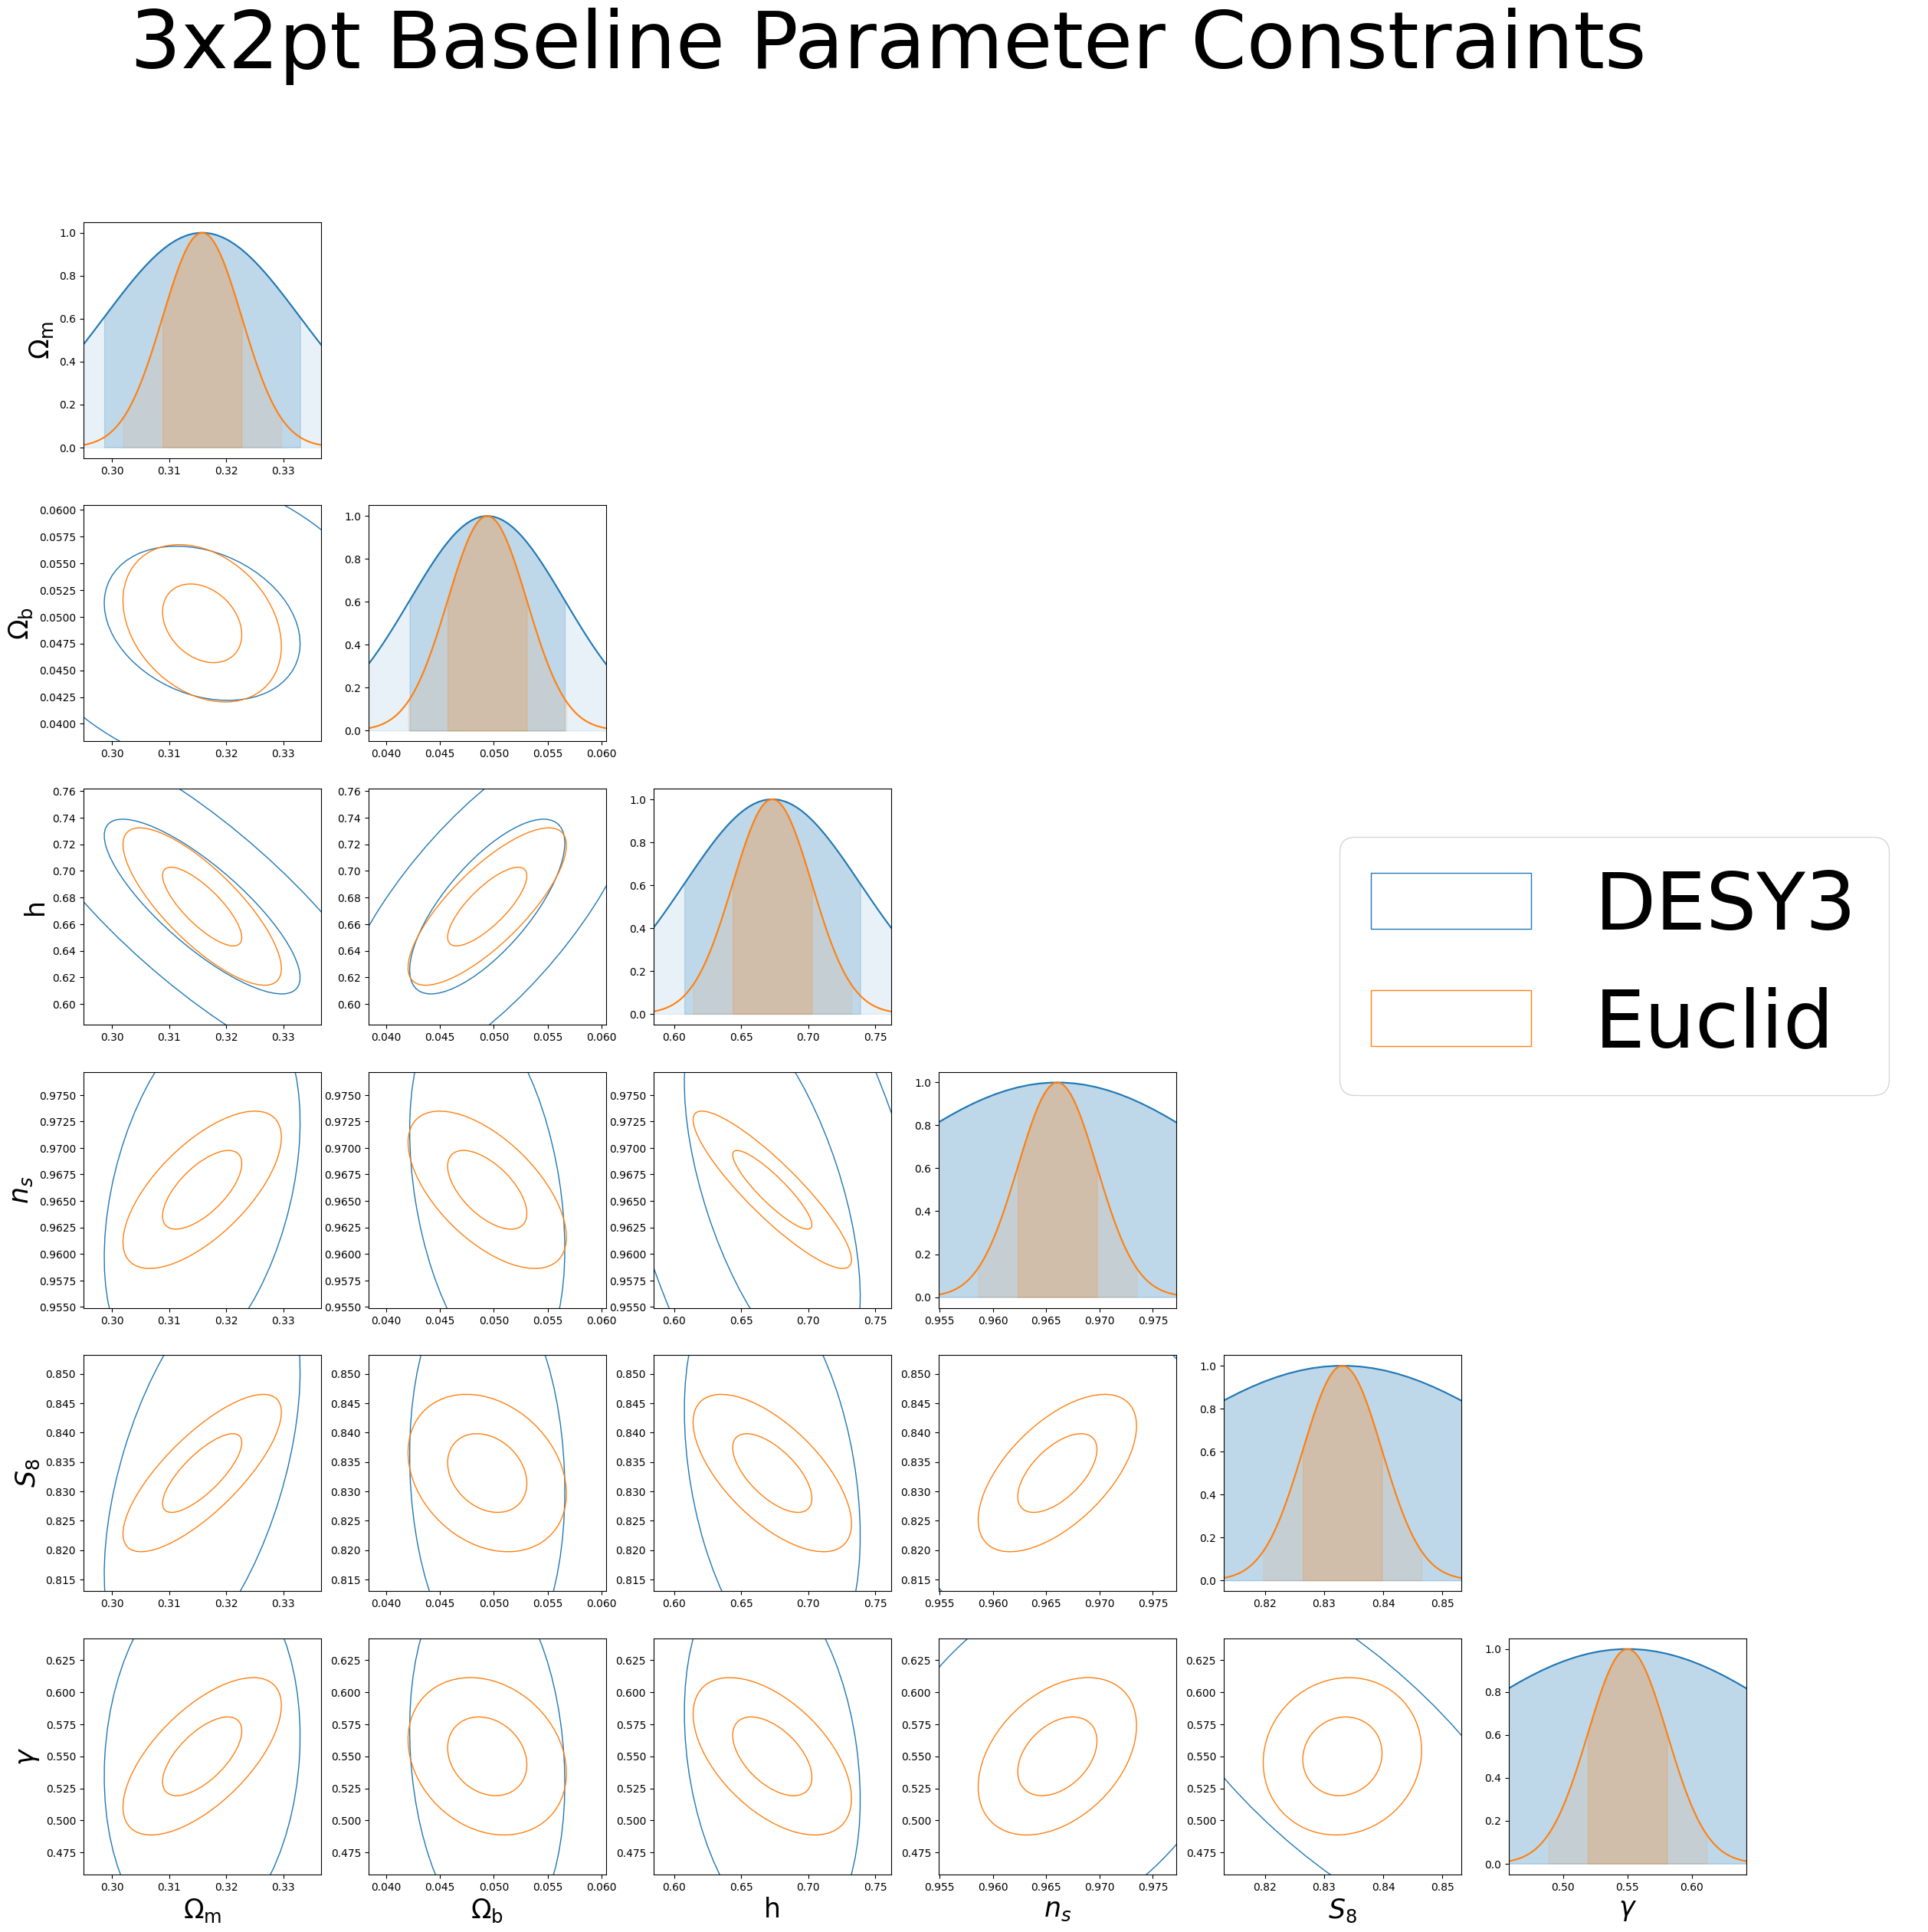

In [5]:
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$', r'$\gamma$')

fig= plt.figure(figsize=((cosmo_param_nr+1)*4, (cosmo_param_nr+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(cosmo_param_nr):
    axes_tuple = ()
    for j in range(cosmo_param_nr):
        if j<i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            ellip_DES = plot_contours(fisher_DESY3_baseline, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C0')
            ellip_Euc = plot_contours(fisher_Euclid_baseline, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C1')
            axes_tuple+=(ax,)
        if j==i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            plot_Gaussian(fisher_DESY3_baseline, fid_vals, i, ax=ax, color='C0')
            shade_Gaussian(fisher_DESY3_baseline, fid_vals, i, ax=ax, color='C0')
            plot_Gaussian(fisher_Euclid_baseline, fid_vals, i, ax=ax, color='C1')
            shade_Gaussian(fisher_Euclid_baseline, fid_vals, i, ax=ax, color='C1')
            axes_tuple+=(ax,)
    axes.append(axes_tuple)
for i in np.arange(cosmo_param_nr):
    axes[i][0].set_ylabel(param_names[i], fontsize=25)
    axes[-1][i].set_xlabel(param_names[i], fontsize=25)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        if j<i:
            axes[i][j]

fig.legend([ellip_DES[0], ellip_Euc[0]], ['DESY3', 'Euclid'], loc='center right', fontsize=75)

fig.suptitle('3x2pt Baseline Parameter Constraints', fontsize=75)

In [6]:
cosmo_param_nr = 3
inds = np.array([0,4,5])
mat_inds = np.ix_(inds, inds)
print(mat_inds)
small_DES = np.linalg.inv(np.linalg.inv(fisher_DESY3_baseline)[mat_inds])
small_Euc = np.linalg.inv(np.linalg.inv(fisher_Euclid_baseline)[mat_inds])

fid_vals = fid_vals[inds]

(array([[0],
       [4],
       [5]]), array([[0, 4, 5]]))


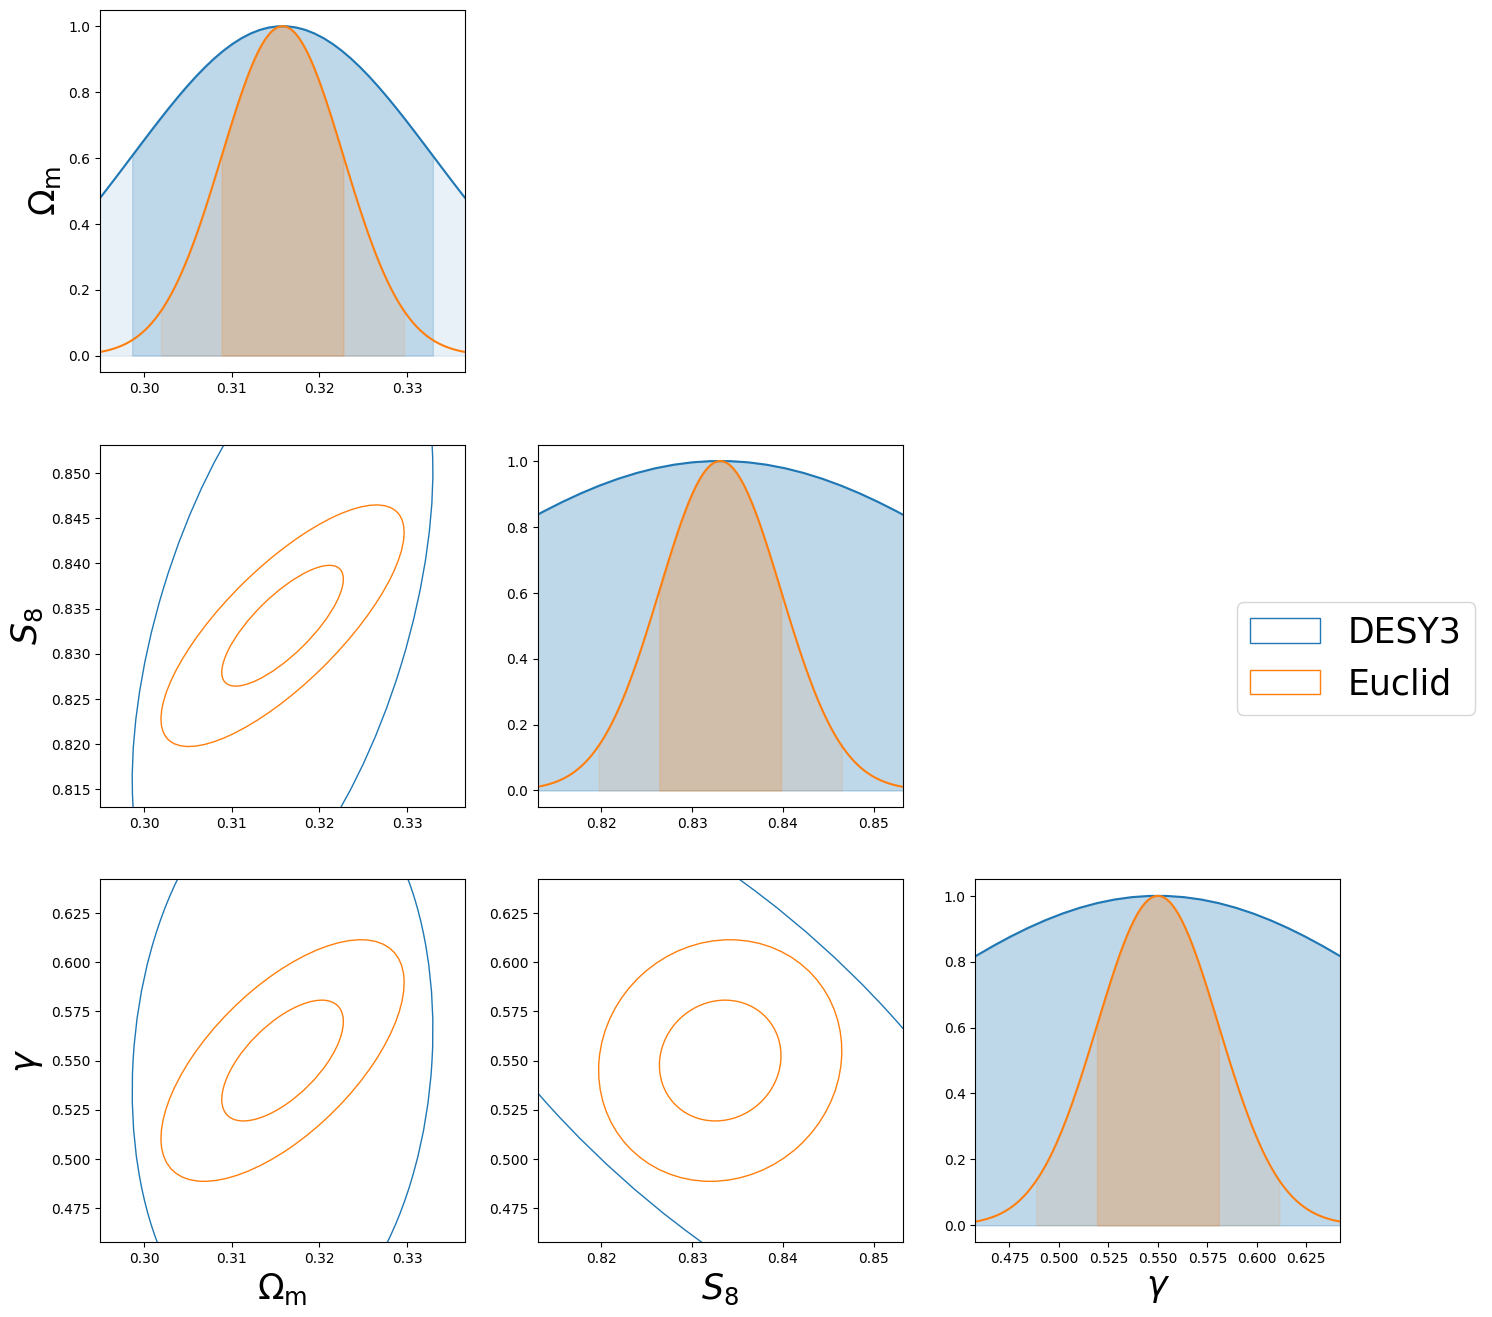

In [7]:
param_names = (r'$\Omega_\mathrm{m}$', r'$S_8$', r'$\gamma$')

fig= plt.figure(figsize=((cosmo_param_nr+1)*4, (cosmo_param_nr+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(cosmo_param_nr):
    axes_tuple = ()
    for j in range(cosmo_param_nr):
        if j<i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            ellip_DES = plot_contours(small_DES, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C0')
            ellip_Euc = plot_contours(small_Euc, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C1')
            axes_tuple+=(ax,)
        if j==i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            plot_Gaussian(small_DES, fid_vals, i, ax=ax, color='C0')
            shade_Gaussian(small_DES, fid_vals, i, ax=ax, color='C0')
            plot_Gaussian(small_Euc, fid_vals, i, ax=ax, color='C1')
            shade_Gaussian(small_Euc, fid_vals, i, ax=ax, color='C1')
            axes_tuple+=(ax,)
    axes.append(axes_tuple)
for i in np.arange(cosmo_param_nr):
    axes[i][0].set_ylabel(param_names[i], fontsize=25)
    axes[-1][i].set_xlabel(param_names[i], fontsize=25)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        if j<i:
            axes[i][j]

fig.legend([ellip_DES[0], ellip_Euc[0]], ['DESY3', 'Euclid'], loc='center right', fontsize=25)

## Extension 1 parameter set - \{$\Omega_m, \Omega_b, w_0, w_a, h, n_s, S_8, \gamma$\}

In [8]:
cosmo_param_nr = 8

#Get matrices
fid_vals, fisher_DESY3_Ext1 = loadFisher(fname='Results/Ext1-S8/Ext1-S8-DESY3-3x2.csv')
fid_vals, fisher_Euclid_Ext1 = loadFisher(fname='Results/Ext1-S8/Ext1-S8-Euclid-3x2.csv')

#Marginalize over nuisance parameters
fisher_DESY3_Ext1 = np.linalg.inv(np.linalg.inv(fisher_DESY3_Ext1)[:cosmo_param_nr, :cosmo_param_nr])
fisher_Euclid_Ext1 = np.linalg.inv(np.linalg.inv(fisher_Euclid_Ext1)[:cosmo_param_nr, :cosmo_param_nr])

fid_vals = fid_vals[:cosmo_param_nr]

Text(0.5, 0.98, '3x2pt Baseline Params + $w_0,w_a$ Constraints')

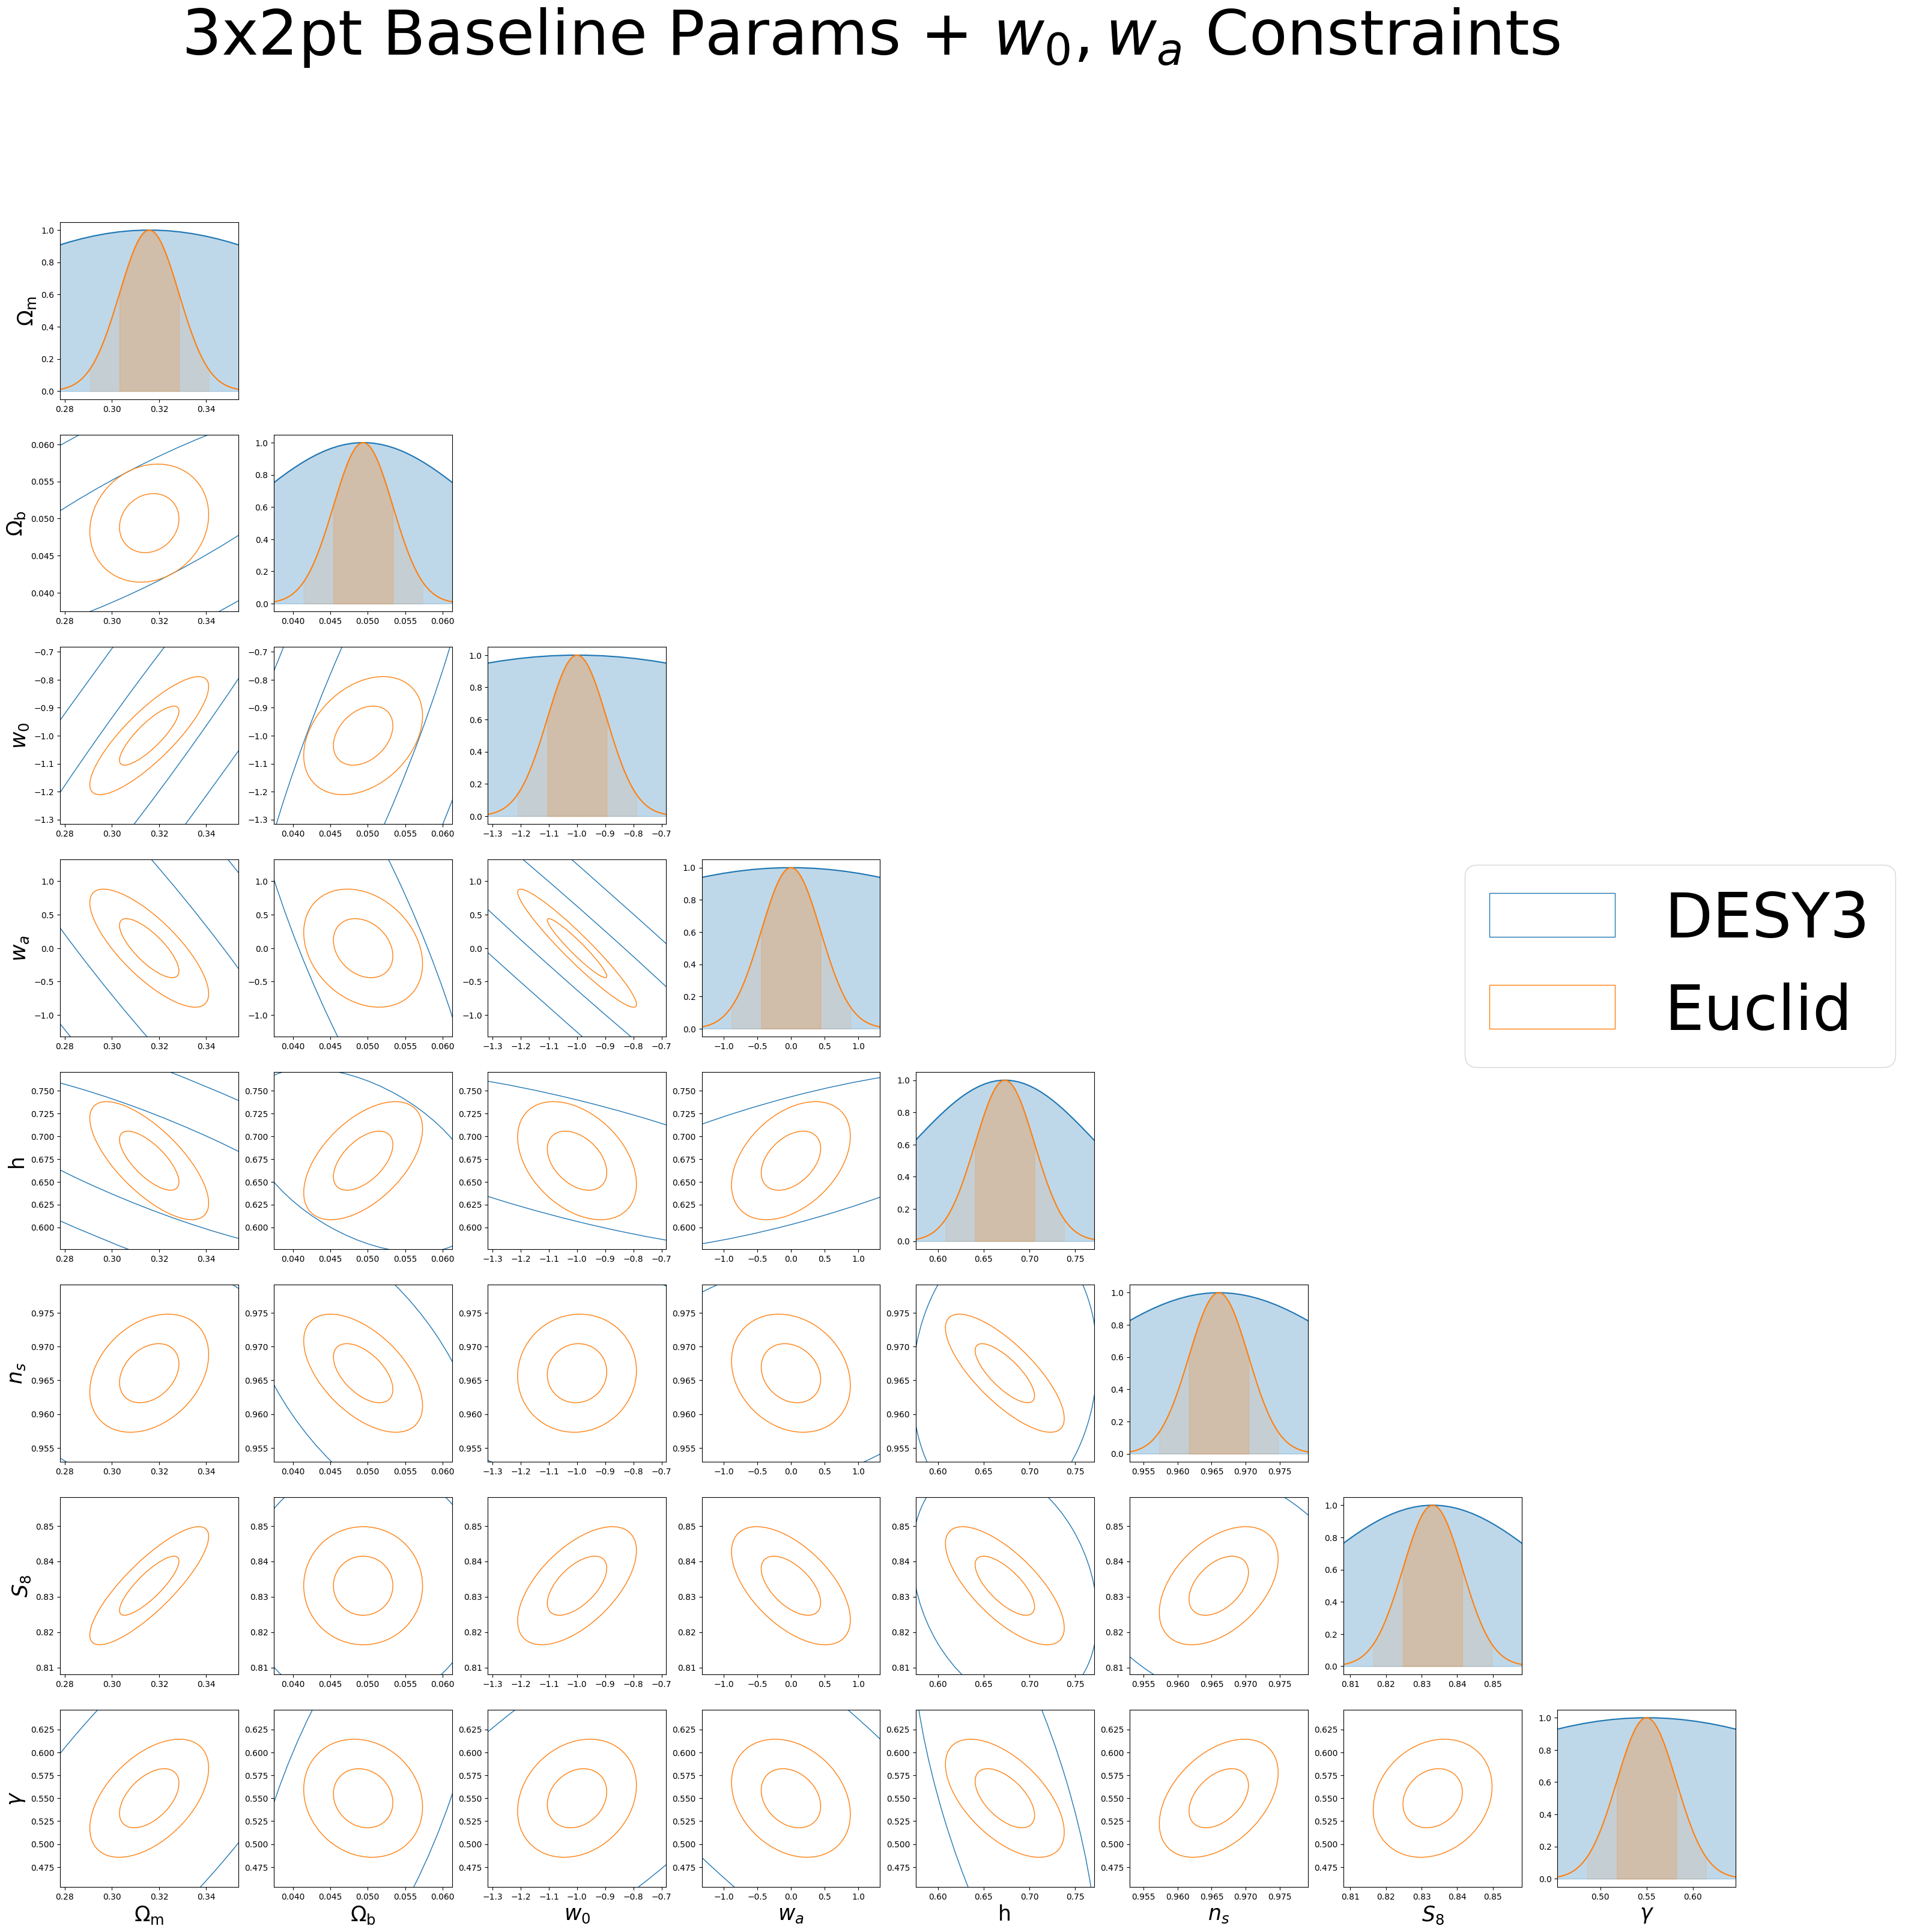

In [9]:
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$w_0$', r'$w_a$', 'h', r'$n_s$', r'$S_8$', r'$\gamma$')

fig= plt.figure(figsize=((cosmo_param_nr+1)*4, (cosmo_param_nr+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(cosmo_param_nr):
    axes_tuple = ()
    for j in range(cosmo_param_nr):
        if j<i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            ellip_DES = plot_contours(fisher_DESY3_Ext1, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C0')
            ellip_Euc = plot_contours(fisher_Euclid_Ext1, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C1')
            axes_tuple+=(ax,)
        if j==i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            plot_Gaussian(fisher_DESY3_Ext1, fid_vals, i, ax=ax, color='C0')
            shade_Gaussian(fisher_DESY3_Ext1, fid_vals, i, ax=ax, color='C0')
            plot_Gaussian(fisher_Euclid_Ext1, fid_vals, i, ax=ax, color='C1')
            shade_Gaussian(fisher_Euclid_Ext1, fid_vals, i, ax=ax, color='C1')
            axes_tuple+=(ax,)
    axes.append(axes_tuple)
for i in np.arange(cosmo_param_nr):
    axes[i][0].set_ylabel(param_names[i], fontsize=25)
    axes[-1][i].set_xlabel(param_names[i], fontsize=25)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        if j<i:
            axes[i][j]

fig.legend([ellip_DES[0], ellip_Euc[0]], ['DESY3', 'Euclid'], loc='center right', fontsize=75)

fig.suptitle(r'3x2pt Baseline Params + $w_0,w_a$ Constraints', fontsize=75)

## Extension 2 parameter set - \{$\Omega_k, \Omega_m, \Omega_b, w_0, w_a, h, n_s, S_8, \gamma$\}

In [10]:
cosmo_param_nr = 9

#Get matrices
fid_vals, fisher_DESY3_Ext2 = loadFisher(fname='Results/Ext2-S8/Ext2-S8-DESY3-3x2.csv')
fid_vals, fisher_Euclid_Ext2 = loadFisher(fname='Results/Ext2-S8/Ext2-S8-Euclid-3x2.csv')

#Marginalize over nuisance parameters
fisher_DESY3_Ext2 = np.linalg.inv(np.linalg.inv(fisher_DESY3_Ext2)[:cosmo_param_nr, :cosmo_param_nr])
fisher_Euclid_Ext2 = np.linalg.inv(np.linalg.inv(fisher_Euclid_Ext2)[:cosmo_param_nr, :cosmo_param_nr])

fid_vals = fid_vals[:cosmo_param_nr]

Text(0.5, 0.98, '3x2pt Baseline + $\\Omega_k,w_0,w_a$ Constraints')

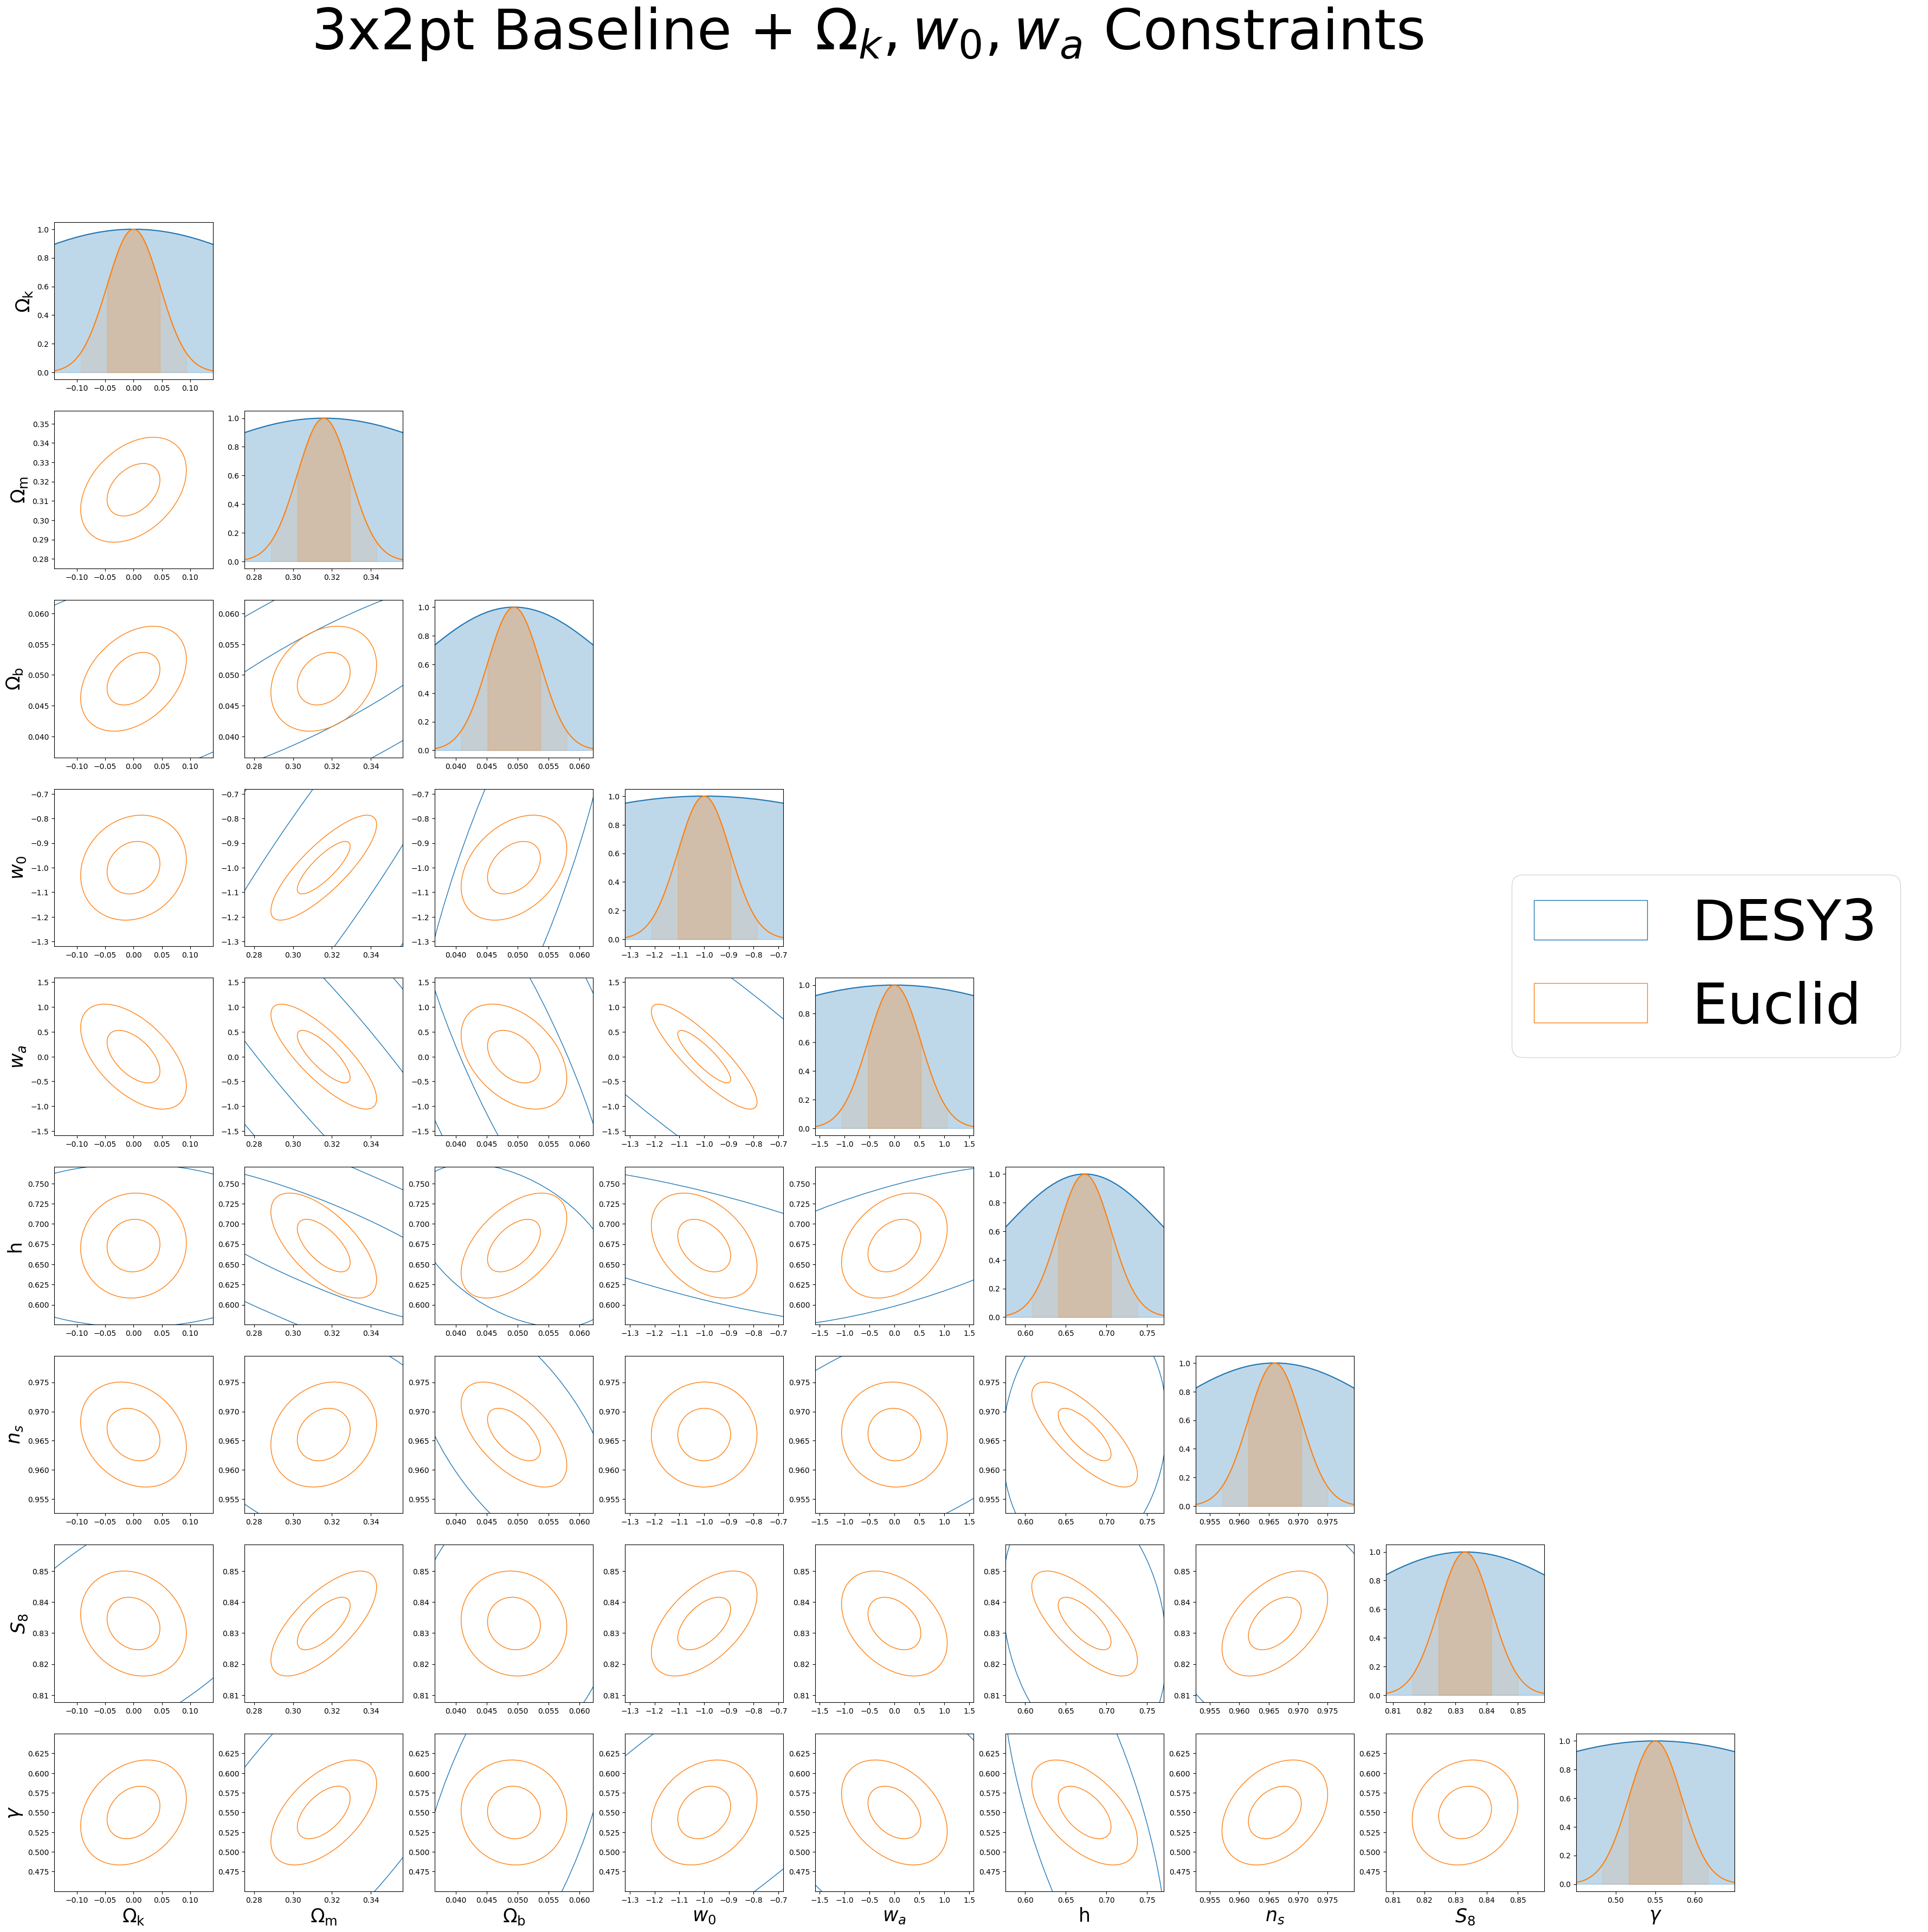

In [11]:
param_names = (r'$\Omega_\mathrm{k}$', r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$w_0$', r'$w_a$', 'h', r'$n_s$', r'$S_8$', r'$\gamma$')

fig= plt.figure(figsize=((cosmo_param_nr+1)*4, (cosmo_param_nr+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(cosmo_param_nr):
    axes_tuple = ()
    for j in range(cosmo_param_nr):
        if j<i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            ellip_DES = plot_contours(fisher_DESY3_Ext2, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C0')
            ellip_Euc = plot_contours(fisher_Euclid_Ext2, fid_vals, np.array([j,i]), ax=ax, fill=False,color='C1')
            axes_tuple+=(ax,)
        if j==i:
            ax = plt.subplot(cosmo_param_nr,cosmo_param_nr,i*cosmo_param_nr+j+1)
            plot_Gaussian(fisher_DESY3_Ext2, fid_vals, i, ax=ax, color='C0')
            shade_Gaussian(fisher_DESY3_Ext2, fid_vals, i, ax=ax, color='C0')
            plot_Gaussian(fisher_Euclid_Ext2, fid_vals, i, ax=ax, color='C1')
            shade_Gaussian(fisher_Euclid_Ext2, fid_vals, i, ax=ax, color='C1')
            axes_tuple+=(ax,)
    axes.append(axes_tuple)
for i in np.arange(cosmo_param_nr):
    axes[i][0].set_ylabel(param_names[i], fontsize=25)
    axes[-1][i].set_xlabel(param_names[i], fontsize=25)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        if j<i:
            axes[i][j]

fig.legend([ellip_DES[0], ellip_Euc[0]], ['DESY3', 'Euclid'], loc='center right', fontsize=75)

fig.suptitle(r'3x2pt Baseline + $\Omega_k,w_0,w_a$ Constraints', fontsize=75)

## Compare figure of merit

In [12]:
FoM_baseline = (np.linalg.det(fisher_Euclid_baseline)/np.linalg.det(fisher_DESY3_baseline))**5
FoM_ext1 = (np.linalg.det(fisher_Euclid_Ext1)/np.linalg.det(fisher_DESY3_Ext1))**.5
FoM_ext2 = (np.linalg.det(fisher_Euclid_Ext2)/np.linalg.det(fisher_DESY3_Ext2))**.5

print(FoM_baseline, "\n", FoM_ext1,"\n",FoM_ext2)

9.32500126031922e+33 
 108776.03918023633 
 690781.9186338369
